# The goal of the project is to find the health insurance cost incured by Individuals based on thier age, gender, BMI, number of children, smoking habit and geo-location using multiple linear regression


IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# read the csv file 
insurance_df = pd.read_csv('insurance.csv')

In [4]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# check if there are any Null
insurance_df.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

In [6]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
insurance_df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [8]:
# convert categorical variable to numerical
insurance_df['sex'].replace(['male', 'female'],[1, 0], inplace=True)
insurance_df['smoker'].replace(['yes', 'no'],[1, 0], inplace=True)
insurance_df['region'].replace(['southwest', 'southeast', 'northwest', 'northeast'],[3,2,1, 0], inplace=True)
insurance_df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


VISUALIZE DATASET

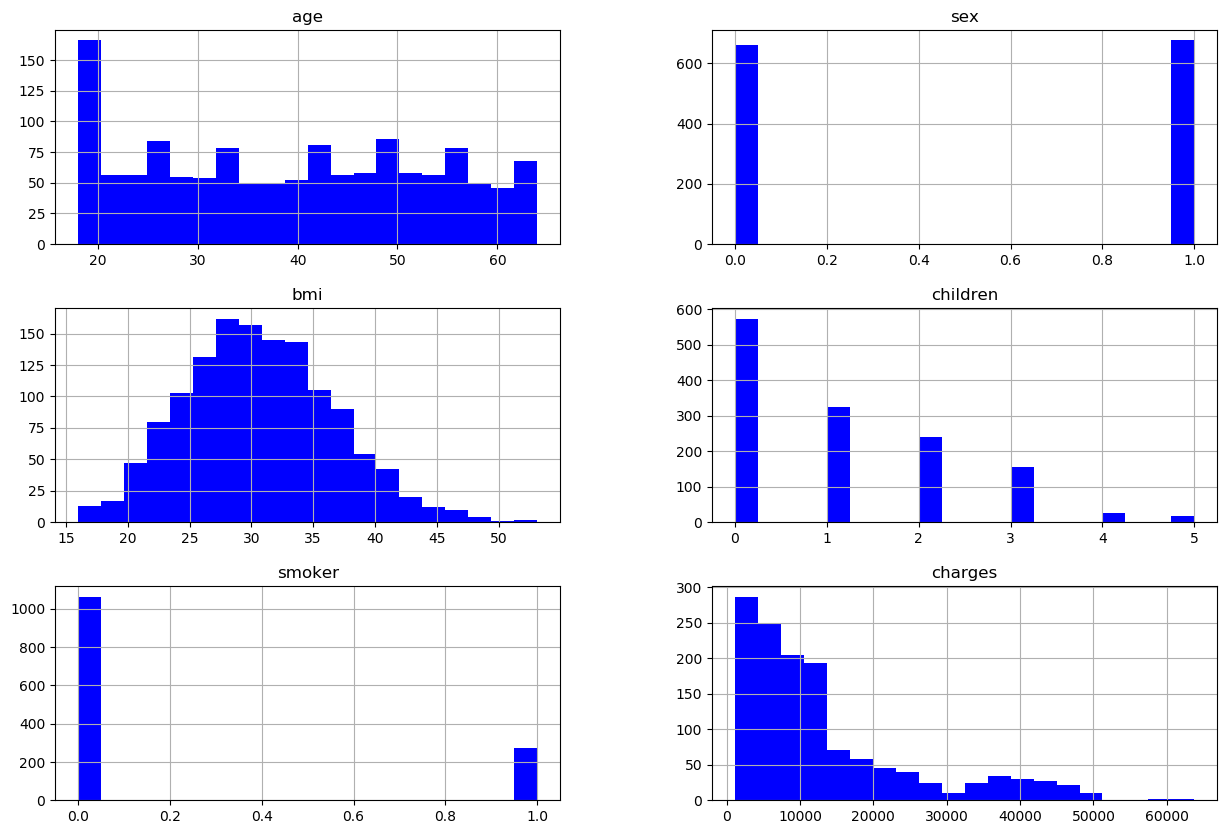

In [9]:
insurance_df[['age', 'sex', 'bmi', 'children', 'smoker', 'charges']].hist(bins = 20, figsize = (15,10), color = 'b')
plt.show()

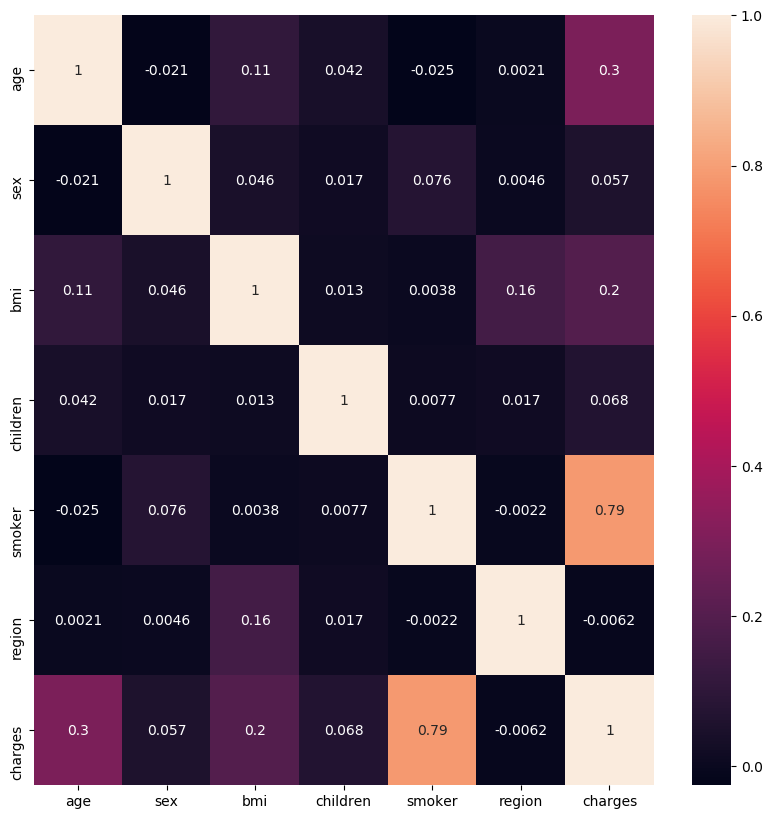

In [10]:
plt.figure(figsize = (10,10))
sns.heatmap(insurance_df.corr(), annot = True)
plt.show()

CREATE TRAINING AND TESTING DATASET

We want to predict charges, so charge is dependent variable and others are features(independent variable)

In [11]:
X = insurance_df.drop(columns =['charges'])
y = insurance_df['charges']

In [12]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [13]:
y = y.reshape(-1,1)
y.shape

(1338, 1)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

# TRAIN THE MODEL

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
regresssion_model_sklearn = LinearRegression()
regresssion_model_sklearn.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
#Prediction
y_predict = regresssion_model_sklearn.predict(X_test)

In [18]:
#Evaluation
accuracy = regresssion_model_sklearn.score(X_test, y_test)
accuracy

0.7844132921177845

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error

MSE = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

In [20]:
print('MSE =',MSE,'\nR2 =', r2) 

MSE = 0.3248758 
R2 = 0.7844132921177845


# TRAIN THE MODEL USING SAGEMAKER

In [21]:
import sagemaker
import boto3
from sagemaker import Session

sagemaker_session = sagemaker.Session()
bucket = 'sagemaker--project'
prefix = 'poly_linear_learner' 
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::328532437175:role/service-role/AmazonSageMaker-ExecutionRole-20230427T180526


In [22]:
y_train = y_train[:,0]

In [23]:
y_train.shape

(1070,)

In [24]:
import io 
import numpy as np
import sagemaker.amazon.common as smac 

buf = io.BytesIO() 
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 

0

In [25]:
import os
key = 'linear-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker--project/poly_linear_learner/train/linear-train-data


In [26]:
y_test = y_test[:,0]
buf = io.BytesIO() 
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0) 

0

In [27]:
key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://sagemaker--project/poly_linear_learner/test/linear-test-data


In [28]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker--project/poly_linear_learner/output


In [34]:
from sagemaker.amazon.amazon_estimator import get_image_uri 
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [38]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count = 1, 
                                       train_instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session,
                                       train_use_spot_instances = True,
                                       train_max_run = 300,
                                       train_max_wait = 600)

linear.set_hyperparameters(feature_dim = 6,
                           predictor_type = 'regressor',
                           mini_batch_size = 4,
                           epochs = 100,
                           num_models = 32,
                           loss = 'absolute_loss')

linear.fit({'train': s3_train_data})

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-04-28-22-19-00-490


2023-04-28 22:19:00 Starting - Starting the training job...
2023-04-28 22:19:24 Starting - Preparing the instances for training.........
2023-04-28 22:20:55 Downloading - Downloading input data...
2023-04-28 22:21:21 Training - Downloading the training image......
2023-04-28 22:22:41 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/28/2023 22:22:49 INFO 140490179946304] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

# DEPLOY THE MODEL 

In [39]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-04-28-22-44-07-434
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-04-28-22-44-07-434
INFO:sagemaker:Creating endpoint with name linear-learner-2023-04-28-22-44-07-434


------!

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

In [ ]:
result = linear_regressor.predict(X_test)
predictions = np.array([r['score'] for r in result['predictions']])
predictions

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

MSE = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print('MSE =',MSE,'\nR2 =', r2) 

In [ ]:
# Delete the end-point
linear_regressor.delete_endpoint()